
--- Evaluating Density Level: 1.00% ---
Density: 1.00%, Average Lanczos Basis Size: 94.0

--- Evaluating Density Level: 5.00% ---
Density: 5.00%, Average Lanczos Basis Size: 129.5

--- Evaluating Density Level: 10.00% ---
Density: 10.00%, Average Lanczos Basis Size: 74.5

--- Evaluating Density Level: 15.00% ---
Density: 15.00%, Average Lanczos Basis Size: 70.5

--- Evaluating Density Level: 20.00% ---
Density: 20.00%, Average Lanczos Basis Size: 68.0

--- Evaluating Density Level: 25.00% ---
Density: 25.00%, Average Lanczos Basis Size: 168.5

--- Evaluating Density Level: 30.00% ---
Density: 30.00%, Average Lanczos Basis Size: 122.5

--- Evaluating Density Level: 35.00% ---
Density: 35.00%, Average Lanczos Basis Size: 172.5

--- Evaluating Density Level: 40.00% ---
Density: 40.00%, Average Lanczos Basis Size: 111.5

--- Evaluating Density Level: 45.00% ---
Density: 45.00%, Average Lanczos Basis Size: 82.0

--- Evaluating Density Level: 50.00% ---
Density: 50.00%, Average Lanczos Basi

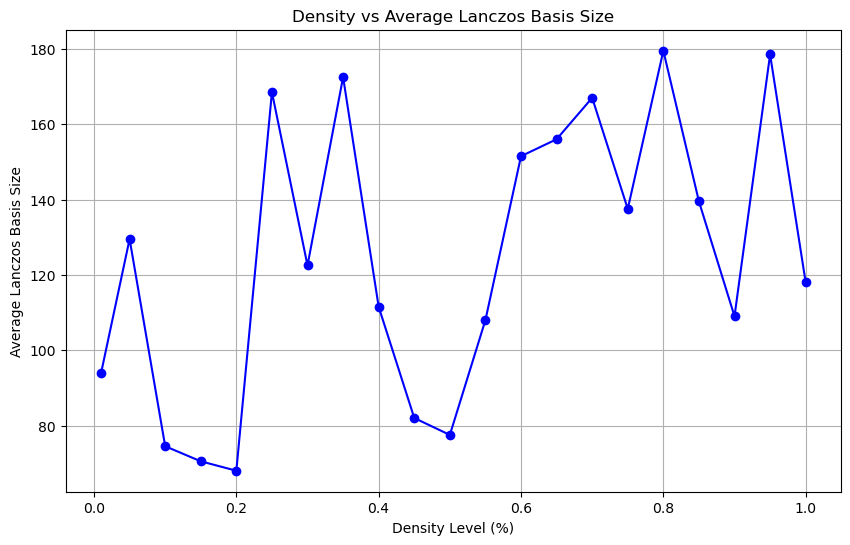

In [1]:
import numpy as np
from scipy.sparse import random as sparse_random
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

def generate_sparse_matrix(size, density):
    diagonal_values = np.linspace(-1, 1, size)
    rvs = np.random.randn  
    upper = sparse_random(size, size, density=density/2, data_rvs=rvs, format='coo')
    matrix_s = upper + upper.T
    matrix_s.setdiag(diagonal_values)
    
    return matrix_s.tocsr()  

def lanczos_algorithm(matrix_s, initial_vector, expected_eigenvalue, tol=1e-6, max_iter=10000):
    m = matrix_s.shape[0]
    krylov_vectors = np.zeros((m, max_iter + 1))
    tridiag_matrix = np.zeros((max_iter + 1, max_iter))
    w = initial_vector / np.linalg.norm(initial_vector)
    krylov_vectors[:, 0] = w
    
    for k in range(max_iter):
        v = matrix_s.dot(krylov_vectors[:, k])
        tridiag_matrix[k, k] = np.dot(krylov_vectors[:, k].conj(), v)
        v = v - tridiag_matrix[k, k] * krylov_vectors[:, k]
        if k > 0:
            v = v - tridiag_matrix[k, k-1] * krylov_vectors[:, k-1]
        tridiag_matrix[k + 1, k] = np.linalg.norm(v)
        if tridiag_matrix[k + 1, k] > tol:
            krylov_vectors[:, k + 1] = v / tridiag_matrix[k + 1, k]
        else:
            print(f"Convergence reached at iteration {k+1}, stopping Lanczos.")
            break
        
        eigenvalues = np.linalg.eigvalsh(tridiag_matrix[:k + 1, :k + 1])
        estimated_eigenvalue = eigenvalues[0]

        if abs(estimated_eigenvalue - expected_eigenvalue) < tol:
            return k + 1
        if estimated_eigenvalue<=expected_eigenvalue:
            return k + 1
    
    return max_iter

def evaluate_average_iterations(size, density_levels, initial_vector, num_trials=2, tol=1e-6, max_iter=10000):
    avg_iterations_per_density = []
    
    for density in density_levels:
        print(f"\n--- Evaluating Density Level: {density:.2%} ---")
        total_iterations = 0
        for trial in range(num_trials):
            matrix_s = generate_sparse_matrix(size, density)
            exact_eigenvalue, _ = eigsh(matrix_s, k=1, which='SA', tol=tol)
            exact_eigenvalue = exact_eigenvalue[0]
            
            num_iterations = lanczos_algorithm(matrix_s, initial_vector, exact_eigenvalue, tol, max_iter)
            total_iterations += num_iterations
        
        avg_iterations = total_iterations / num_trials
        avg_iterations_per_density.append(avg_iterations)
        print(f"Density: {density:.2%}, Average Lanczos Basis Size: {avg_iterations}")
    
    return avg_iterations_per_density

# Parameters
size = 10000
density_levels = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
initial_vector = np.random.rand(size)  # random initial vector

# Evaluate the basis size for different sparsity levels
average_basis_sizes = evaluate_average_iterations(size, density_levels, initial_vector, num_trials=2)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(density_levels, average_basis_sizes, marker='o', linestyle='-', color='b')
plt.xlabel('Density Level (%)')
plt.ylabel('Average Lanczos Basis Size')
plt.title('Density vs Average Lanczos Basis Size')
plt.grid(True)
plt.show()
